# IMPORT LIBRARY

In [1]:
# !pip cache purge
# !pip install catboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import learning_curve
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

import xgboost as xgb
import catboost as cb
import lightgbm as lgb
from xgboost import XGBRegressor, plot_importance
from lightgbm import LGBMRegressor, plot_importance as lgb_plot_importance
from catboost import CatBoostRegressor, Pool

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# LOAD DATASET

In [9]:
# df_1300 = pd.read_csv('/content/drive/MyDrive/UNIVERSITAS TELKOM S2/SEMESTER 3/DAMIN/UAS - Project 2/medical1300.csv')
# df_900 = pd.read_csv('/content/drive/MyDrive/UNIVERSITAS TELKOM S2/SEMESTER 3/DAMIN/UAS - Project 2/medical900.csv')
df_1300 = pd.read_csv('dataset/medical1300.csv')
df_900 = pd.read_csv('dataset/medical900.csv')
df_900.shape,df_1300.shape

((986, 11), (1338, 7))

In [10]:
df_1300.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [11]:
df_900.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000


# PREPROCESSING

In [12]:
medical900 = df_900.copy()
medical1300 = df_1300.copy()

In [13]:
# Preprocess medical1300.csv
def preprocess_medical1300(df):
    if df.isnull().sum().sum() > 0:
        df = df.dropna()

    # Check for duplicate values
    df = df.drop_duplicates()
    
    X = df.drop(columns=['charges'])
    y = df['charges']
    
    # categorical_features = ['sex', 'smoker', 'region']
    # numerical_features = ['age', 'bmi', 'children']
    
    # preprocessor = ColumnTransformer(
    #     transformers=[
    #         ('num', 'passthrough', numerical_features),
    #         ('cat', OneHotEncoder(), categorical_features)
    #     ]
    # )
    
    X = pd.get_dummies(X, drop_first=True)
    
    # X = preprocessor.fit_transform(X)
    # return train_test_split(X, y, test_size=0.2, random_state=42)
    return X, y

# Preprocess medical900.csv
def preprocess_medical900(df):
    if df.isnull().sum().sum() > 0:
        df = df.dropna()

    # Check for duplicate values
    df = df.drop_duplicates()
    
    X = df.drop(columns=['PremiumPrice'])
    y = df['PremiumPrice']
    # return train_test_split(X, y, test_size=0.2, random_state=42)
    return X, y

# Preprocess the datasets
X_1300, y_1300 = preprocess_medical1300(medical1300)
X_900, y_900 = preprocess_medical900(medical900)

# Split the data into training and testing sets
X_train_1300, X_test_1300, y_train_1300, y_test_1300 = train_test_split(X_1300, y_1300, test_size=0.2, random_state=42)
X_train_900, X_test_900, y_train_900, y_test_900 = train_test_split(X_900, y_900, test_size=0.2, random_state=42)

# MODELIING

## LIGHTGBM

### Training & Evaluate

#### Default (No Hyperparameter Tuning)

In [76]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_lightgbm(X_train, X_test, y_train, y_test):
    model = LGBMRegressor(
        n_estimators=100, 
        learning_rate=0.01, 
        num_leaves=10, 
        min_child_weight=1, 
        subsample=1.0, 
        colsample_bytree=1.0, 
        reg_alpha=0.1,
        reg_lambda=0.1,
        verbose=0
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }

    return results

# Evaluate LightGBM model on both datasets
lgbm_results_1300 = evaluate_lightgbm(X_train_1300, X_test_1300, y_train_1300, y_test_1300)
lgbm_results_900 = evaluate_lightgbm(X_train_900, X_test_900, y_train_900, y_test_900)

# Display the results
print("Light GBM Evaluation without Hyperparameter Tuning")
print("Results for medical1300.csv:")
for metric, value in lgbm_results_1300.items():
    print(f"{metric}: {value}")

print("\nResults for medical900.csv:")
for metric, value in lgbm_results_900.items():
    print(f"{metric}: {value}")

Light GBM Evaluation without Hyperparameter Tuning
Results for medical1300.csv:
MAE: 4842.090990823341
MSE: 43577776.76406465
RMSE: 6601.346587179365
R2: 0.7628498575463724

Results for medical900.csv:
MAE: 2792.832588730556
MSE: 12119190.805640789
RMSE: 3481.2628176626927
R2: 0.7157974334092162


#### Hyperparameter Tuning Using Grid Search

In [81]:
def evaluate_lightgbm(X_train, X_test, y_train, y_test):
    model = LGBMRegressor(verbose=0)

    param_grid = {
        'n_estimators': [200, 400, 450],
        'learning_rate': [0.1, 0.01],
        'num_leaves': [10, 20],
        'min_child_weight': [1, 5],
        'subsample': [0.6, 1.0],
        'colsample_bytree': [0.6, 1.0],
        'reg_alpha': [0.1],
        'reg_lambda': [0.1]
    }

    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'Best Params': grid_search.best_params_
    }

    return results, grid_search.cv_results_

# Evaluate LightGBM model on both datasets
lgbm_results_1300,  cv_results_1300 = evaluate_lightgbm(X_train_1300, X_test_1300, y_train_1300, y_test_1300)
lgbm_results_900, cv_results_900  = evaluate_lightgbm(X_train_900, X_test_900, y_train_900, y_test_900)

# Display the results
print("Light GBM Hyperpamater Tuning using Grid Search")
print("Results for medical1300.csv:")
for metric, value in lgbm_results_1300.items():
    print(f"{metric}: {value}")

print("\nResults for medical900.csv:")
for metric, value in lgbm_results_900.items():
    print(f"{metric}: {value}")

Light GBM Hyperpamater Tuning using Grid Search
Results for medical1300.csv:
MAE: 2471.606526840775
MSE: 18025080.884416454
RMSE: 4245.595468767185
R2: 0.9019075589234165
Best Params: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'min_child_weight': 1, 'n_estimators': 450, 'num_leaves': 10, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.6}

Results for medical900.csv:
MAE: 1281.871065299912
MSE: 4688465.510231442
RMSE: 2165.2864730172405
R2: 0.8900525659881554
Best Params: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'min_child_weight': 1, 'n_estimators': 450, 'num_leaves': 20, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.6}


### Save & Load Metrics

In [82]:
import pickle

# Save lgbm_results_1300
with open('metrics/LightGBM_results_1300.pkl', 'wb') as f:
    pickle.dump(lgbm_results_1300, f)

# Save lgbm_results_900
with open('metrics/LightGBM_results_900.pkl', 'wb') as f:
    pickle.dump(lgbm_results_900, f)

In [14]:
# load the model from disk
lgbm_metrics = pickle.load(open('metrics/LightGBM_results_1300.pkl', 'rb'))
print(lgbm_metrics)

# load the model from disk
lgbm_metrics = pickle.load(open('metrics/LightGBM_results_900.pkl', 'rb'))
print(lgbm_metrics)

{'MAE': 2471.606526840775, 'MSE': 18025080.884416454, 'RMSE': 4245.595468767185, 'R2': 0.9019075589234165, 'Best Params': {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'min_child_weight': 1, 'n_estimators': 450, 'num_leaves': 10, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.6}}
{'MAE': 1281.871065299912, 'MSE': 4688465.510231442, 'RMSE': 2165.2864730172405, 'R2': 0.8900525659881554, 'Best Params': {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'min_child_weight': 1, 'n_estimators': 450, 'num_leaves': 20, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.6}}


### Hyperparameter Impact

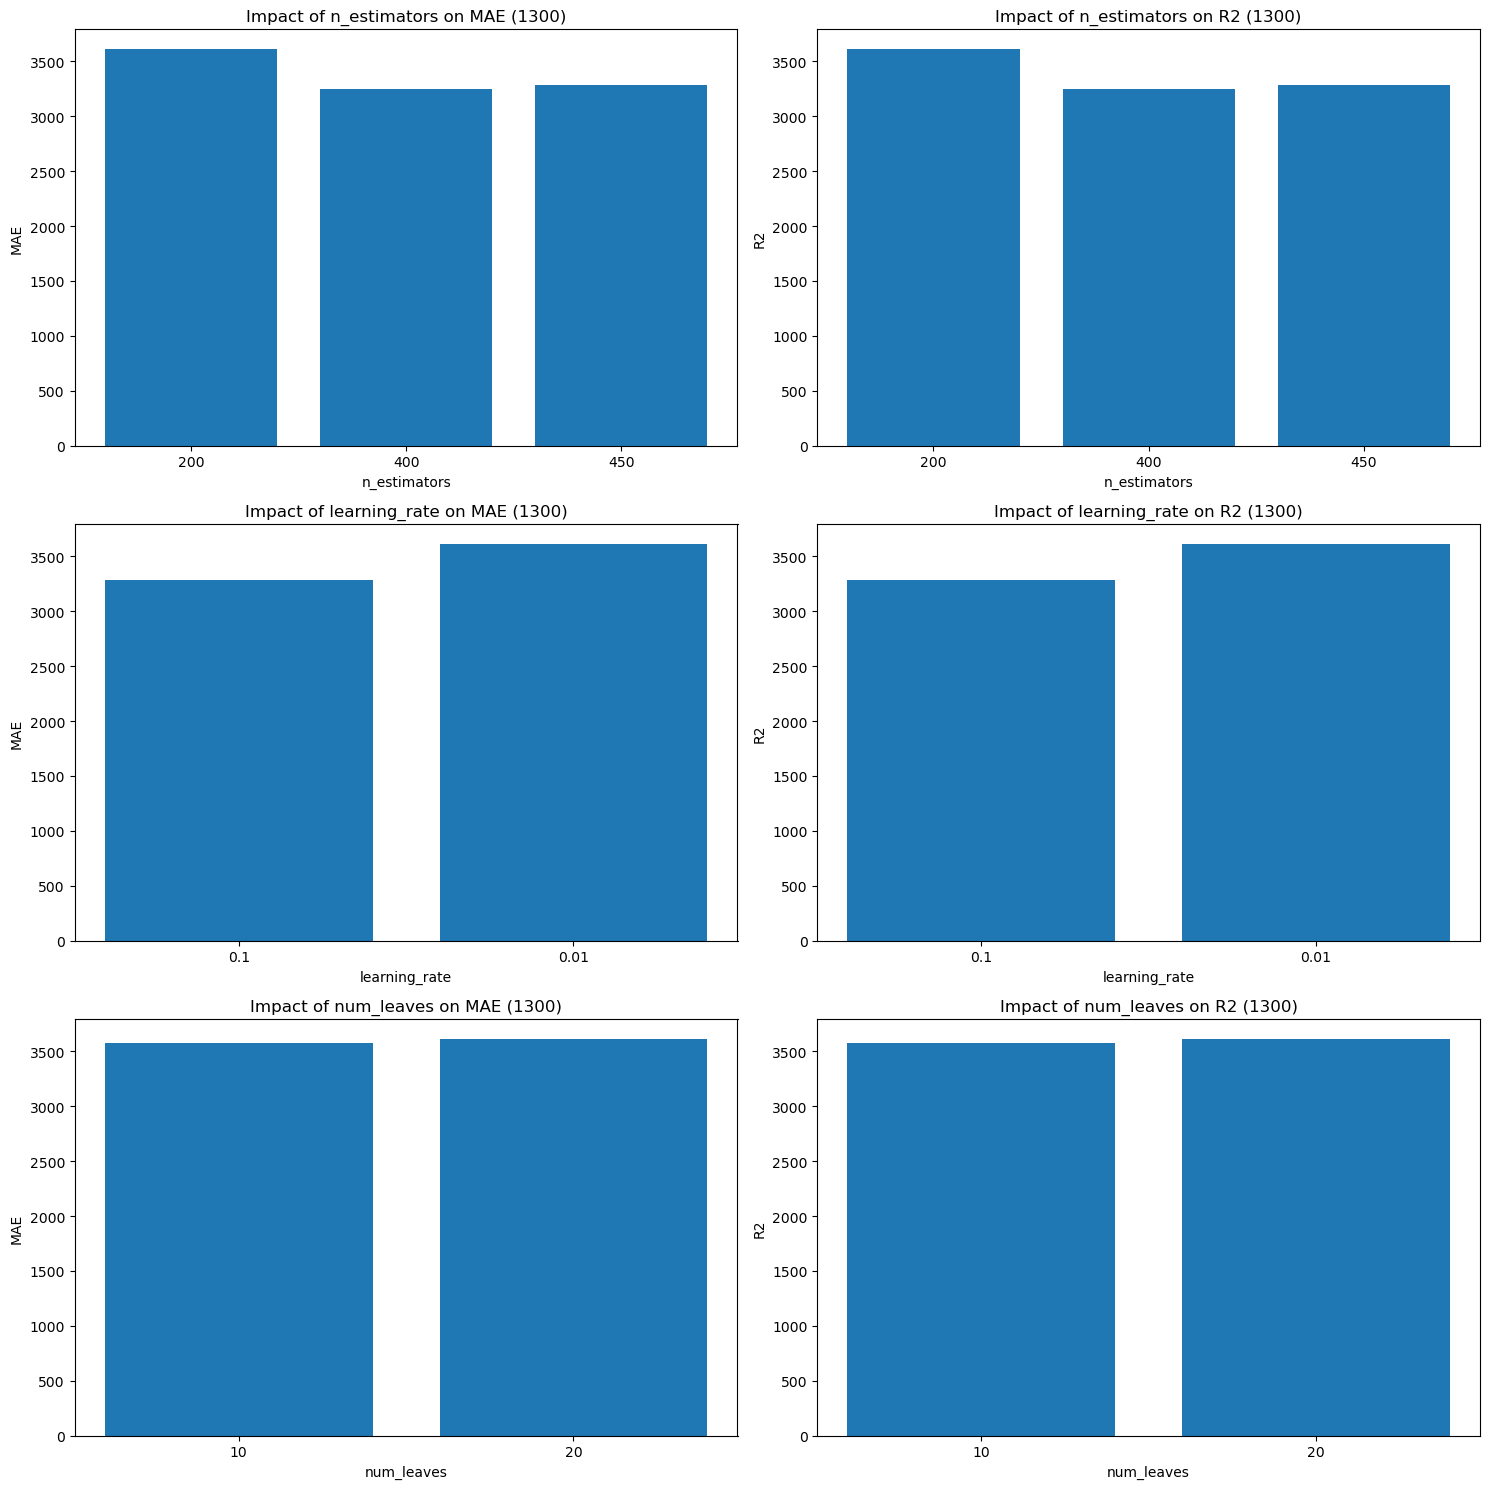

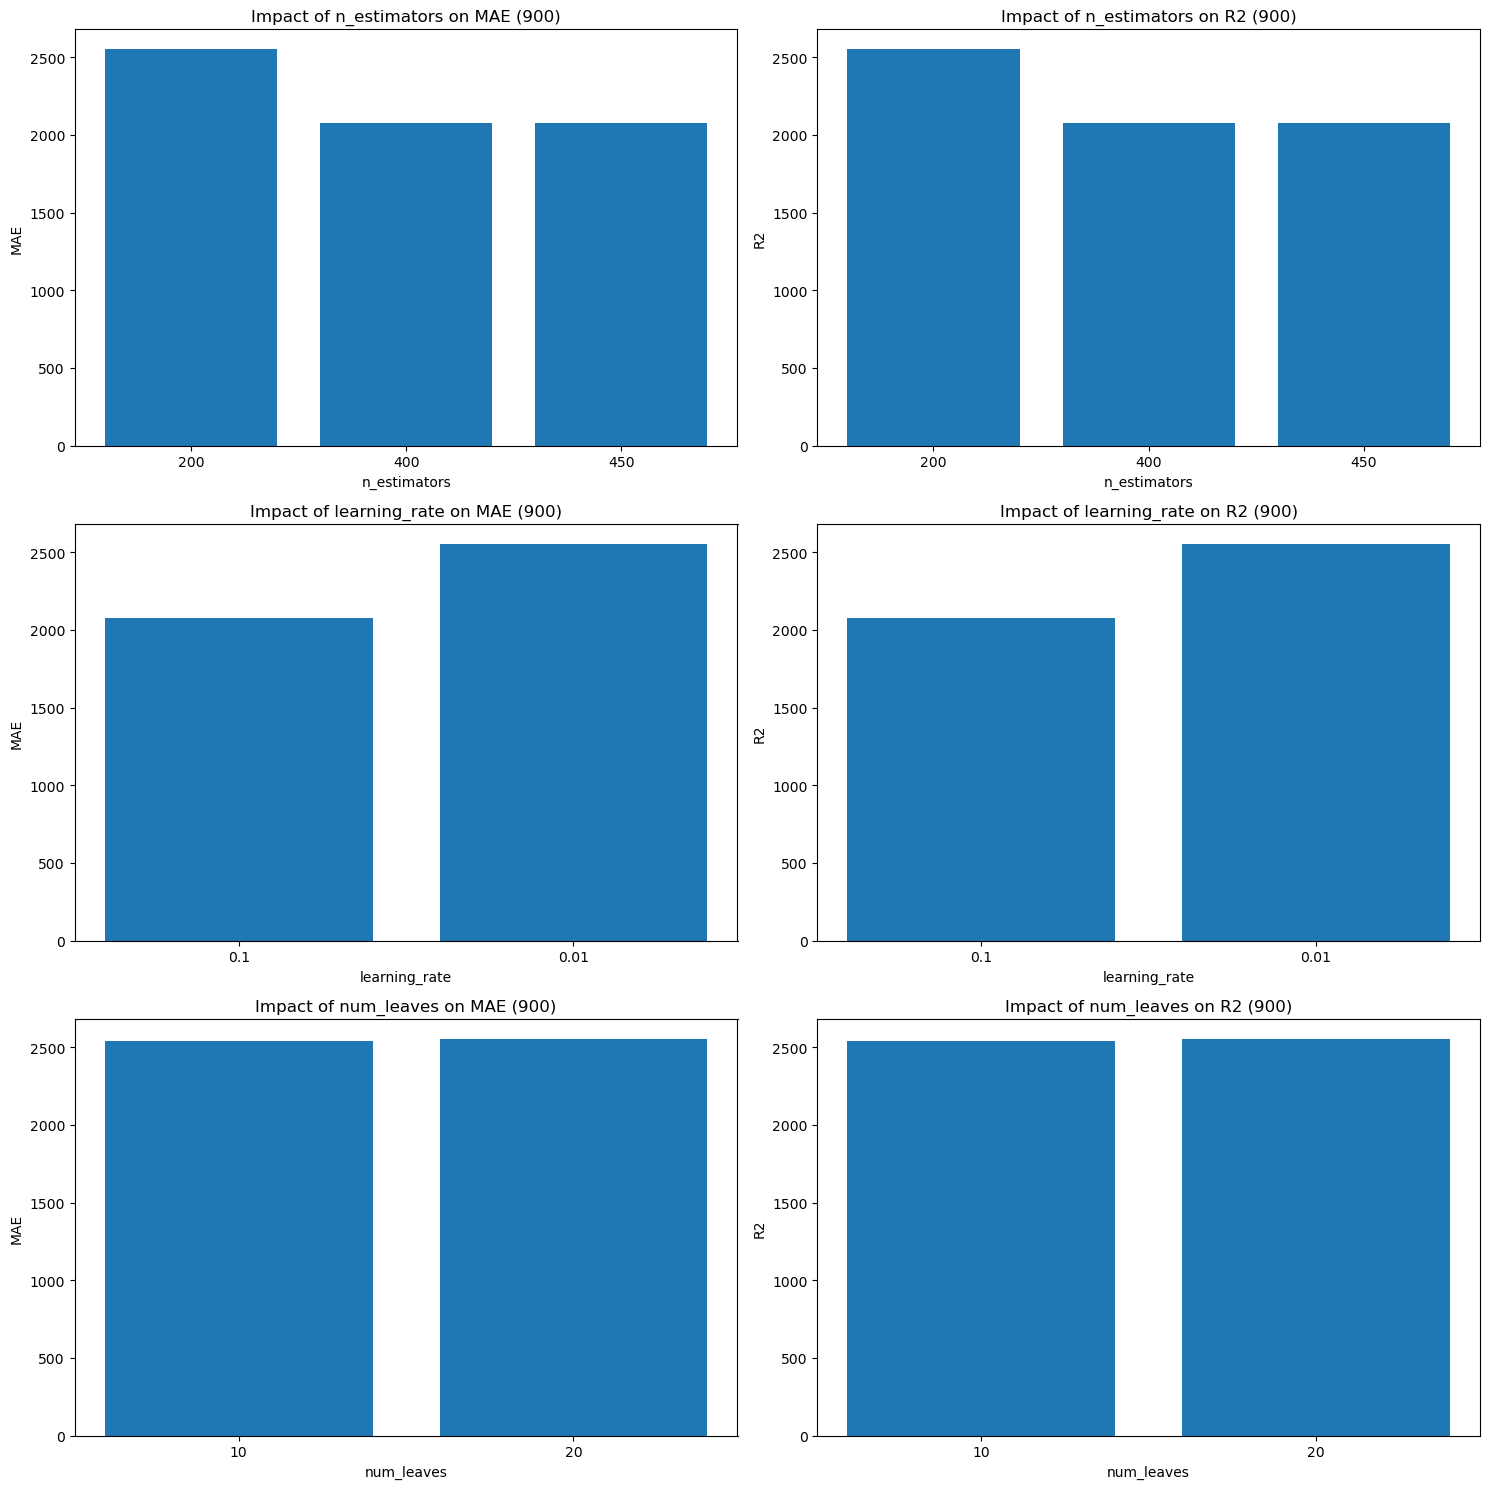

In [116]:
def plot_hyperparameter_impact(cv_results, param_name, metric, title, ax):
    results_df = pd.DataFrame(cv_results)
    param_values = results_df['param_' + param_name].astype(str)
    if metric == 'MAE':
        metric_values = -results_df['mean_test_score']
    elif metric == 'R2':
        metric_values = results_df['mean_test_r2']

    ax.bar(param_values, metric_values)
    ax.set_title(title)
    ax.set_xlabel(param_name)
    ax.set_ylabel(metric)

# Ensure R² values are correctly calculated and plotted
cv_results_1300['mean_test_r2'] = 1 - cv_results_1300['mean_test_score']
cv_results_900['mean_test_r2'] = 1 - cv_results_900['mean_test_score']

# Plotting for medical1300
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

plot_hyperparameter_impact(cv_results_1300, 'n_estimators', 'MAE', 'Impact of n_estimators on MAE (1300)', axes[0, 0])
plot_hyperparameter_impact(cv_results_1300, 'n_estimators', 'R2', 'Impact of n_estimators on R2 (1300)', axes[0, 1])
plot_hyperparameter_impact(cv_results_1300, 'learning_rate', 'MAE', 'Impact of learning_rate on MAE (1300)', axes[1, 0])
plot_hyperparameter_impact(cv_results_1300, 'learning_rate', 'R2', 'Impact of learning_rate on R2 (1300)', axes[1, 1])
plot_hyperparameter_impact(cv_results_1300, 'num_leaves', 'MAE', 'Impact of num_leaves on MAE (1300)', axes[2, 0])
plot_hyperparameter_impact(cv_results_1300, 'num_leaves', 'R2', 'Impact of num_leaves on R2 (1300)', axes[2, 1])

plt.tight_layout()
plt.show()

# Plotting for medical900
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

plot_hyperparameter_impact(cv_results_900, 'n_estimators', 'MAE', 'Impact of n_estimators on MAE (900)', axes[0, 0])
plot_hyperparameter_impact(cv_results_900, 'n_estimators', 'R2', 'Impact of n_estimators on R2 (900)', axes[0, 1])
plot_hyperparameter_impact(cv_results_900, 'learning_rate', 'MAE', 'Impact of learning_rate on MAE (900)', axes[1, 0])
plot_hyperparameter_impact(cv_results_900, 'learning_rate', 'R2', 'Impact of learning_rate on R2 (900)', axes[1, 1])
plot_hyperparameter_impact(cv_results_900, 'num_leaves', 'MAE', 'Impact of num_leaves on MAE (900)', axes[2, 0])
plot_hyperparameter_impact(cv_results_900, 'num_leaves', 'R2', 'Impact of num_leaves on R2 (900)', axes[2, 1])

plt.tight_layout()
plt.show()

### Learning Curve

In [16]:
lgbm_metrics['Best Params']

{'colsample_bytree': 1.0,
 'learning_rate': 0.01,
 'min_child_weight': 1,
 'n_estimators': 450,
 'num_leaves': 20,
 'reg_alpha': 0.1,
 'reg_lambda': 0.1,
 'subsample': 0.6}

In [18]:
# Retrieve the best models from GridSearchCV for medical1300 & medical900 dataset
lgbm_best_1300 = LGBMRegressor(**lgbm_metrics['Best Params'])
lgbm_best_900 = LGBMRegressor(**lgbm_metrics['Best Params'])
# Fit models with the best hyperparameters for medical1300 and medical900 dataset
lgbm_best_1300.fit(X_train_1300, y_train_1300)
lgbm_best_900.fit(X_train_900, y_train_900)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 1069, number of used features: 8
[LightGBM] [Info] Start training from score 13030.203373
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169
[LightGBM] [Info] Number of data points in the train set: 788, number of used features: 10
[LightGBM] [Info] Start training from score 24269.035533


LGBMRegressor(learning_rate=0.01, min_child_weight=1, n_estimators=450,
              num_leaves=20, reg_alpha=0.1, reg_lambda=0.1, subsample=0.6)

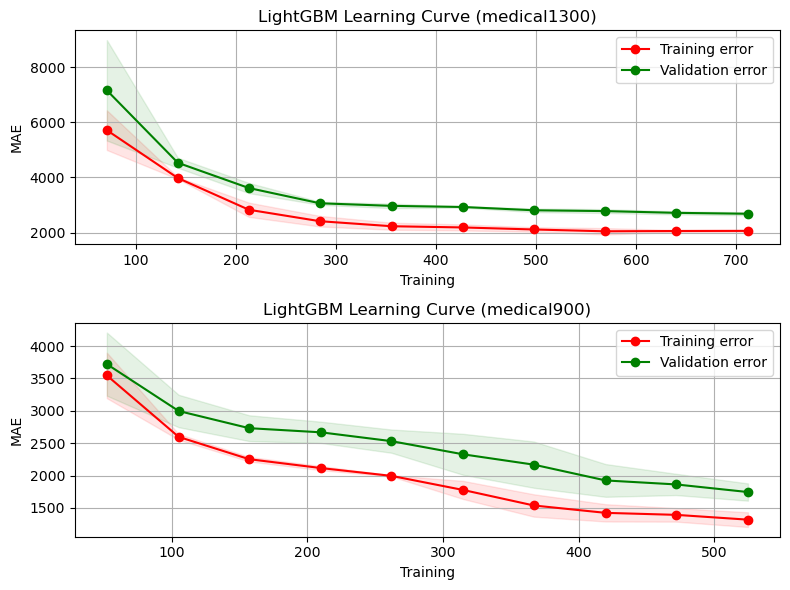

In [19]:
# Function to plot learning curves
def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), random_state=42)

    train_scores_mean = -train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)
    test_scores_std = test_scores.std(axis=1)

    plt.title(title)
    plt.xlabel("Training")
    plt.ylabel("MAE")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training error")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Validation error")

    plt.legend(loc="best")
    return plt

plt.figure(figsize=(8, 6))
# Plot learning curves for each model on the medical1300 dataset
plt.subplot(2,1,1)
plot_learning_curve(lgbm_best_1300, X_train_1300, y_train_1300, "LightGBM Learning Curve (medical1300)")

# Plot learning curves for each model on the medical900 dataset
plt.subplot(2,1,2)
plot_learning_curve(lgbm_best_900, X_train_900, y_train_900, "LightGBM Learning Curve (medical900)")

plt.tight_layout()
plt.show()

### Plot Feature Importane

In [124]:
# Retrieve feature names after preprocessing
feature_names_1300 = pd.get_dummies(medical1300.drop(columns=['charges']), drop_first=True).columns
feature_names_900 = pd.get_dummies(medical900.drop(columns=['PremiumPrice']), drop_first=True).columns

# Preprocess medical1300.csv
def preprocess_medical1300(df):
    if df.isnull().sum().sum() > 0:
        df = df.dropna()

    # Check for duplicate values
    df = df.drop_duplicates()
    
    X = df.drop(columns=['charges'])
    y = df['charges']

    X = pd.get_dummies(X, drop_first=True)
    return X, y
# Preprocess the datasets
X_1300, y_1300 = preprocess_medical1300(medical1300)
X_train_1300, X_test_1300, y_train_1300, y_test_1300 = train_test_split(X_1300, y_1300, test_size=0.2, random_state=42)
lgbm_best_1300.fit(X_train_1300, y_train_1300)

# Plot feature importance for XGBoost with proper feature names
def plot_xgb_importance(model, feature_names, title):
    importance = model.get_booster().get_score(importance_type='weight')
    importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Score'])
    importance_df['Feature'] = importance_df['Feature'].apply(lambda x: feature_names[int(x[1:])])
    importance_df = importance_df.sort_values(by='Score', ascending=False)

    # plt.figure(figsize=(10, 8))
    sns.barplot(x='Score', y='Feature', data=importance_df)
    plt.title(title)
    # plt.show()

# Plot feature importance for LightGBM with proper feature names
def plot_lgb_importance(model, feature_names, title):
    importance = model.booster_.feature_importance(importance_type='split')
    importance_df = pd.DataFrame({'Feature': feature_names, 'Score': importance})
    importance_df = importance_df.sort_values(by='Score', ascending=False)

    # plt.figure(figsize=(10, 8))
    sns.barplot(x='Score', y='Feature', data=importance_df)
    plt.title(title)
    # plt.show()


# Plot feature importance for CatBoost with proper feature names
def plot_catboost_importance(model, feature_names, title):
    feature_importances = model.get_feature_importance()
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
    plt.title(title)
    # plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 1069, number of used features: 8
[LightGBM] [Info] Start training from score 13030.203373


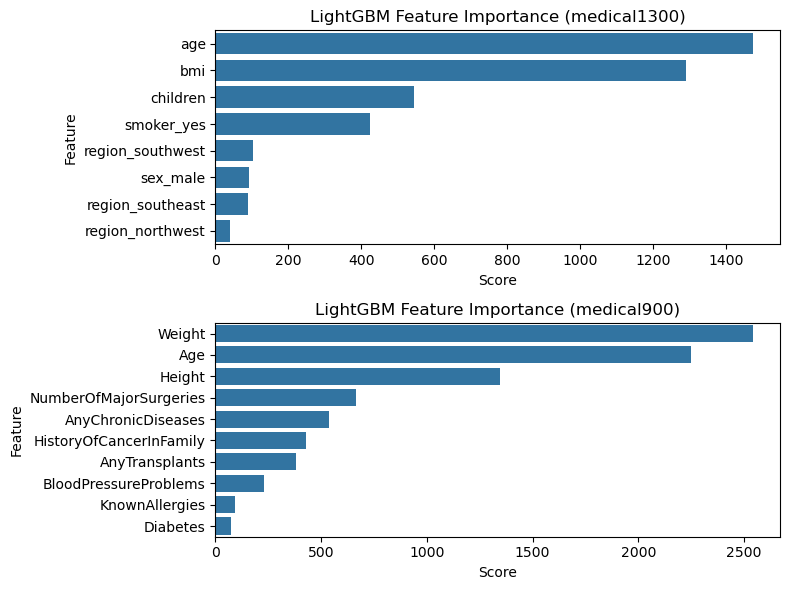

In [125]:
plt.figure(figsize=(8, 6))

plt.subplot(2,1,1)
plot_lgb_importance(lgbm_best_1300, feature_names_1300, 'LightGBM Feature Importance (medical1300)')

plt.subplot(2,1,2)
plot_lgb_importance(lgbm_best_900, feature_names_900, 'LightGBM Feature Importance (medical900)')

plt.tight_layout()
plt.show()

## MODEL FOR COMPARISON

### Training & Evaluate

In [126]:
def evaluate_models(X_train, X_test, y_train, y_test):
    models = {
        'Linear Regression': LinearRegression(),
        'SVM': SVR(),
        'Decision Tree': DecisionTreeRegressor(),
        'Random Forest': RandomForestRegressor(),
        'AdaBoost': AdaBoostRegressor(),
        'Gradient Boosting': GradientBoostingRegressor(),
        'XGBoost': XGBRegressor(verbosity=0),
        'CatBoost': CatBoostRegressor(verbose=0)
    }

    param_grids = {
        'Linear Regression': {},
        'SVM': {
            'C': [0.1, 1, 10],
            'epsilon': [0.1, 0.01, 0.001],
            'kernel': ['linear']
        },
        'Decision Tree': {
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 10, 20],
            'min_samples_leaf': [1, 5, 10]
        },
        'Random Forest': {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20],
            'max_leaf_nodes': [3, 6, 9],
        },
        'AdaBoost': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.1, 0.01, 0.001]
        },
        'Gradient Boosting': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.1, 0.01, 0.001],
            'max_depth':  [2, 3, 5],
        },
        'XGBoost': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.1, 0.01, 0.001],
            'max_depth':  [2, 3, 5],
        },
        'CatBoost': {
            'iterations': [100, 200, 300],
            'learning_rate': [0.1, 0.01, 0.001],
            'depth':  [2, 3, 5],
        }
    }

    results = {}

    for name, model in models.items():
        if name in param_grids:
            grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
        else:
            grid_search = GridSearchCV(model, {}, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_

        y_pred = best_model.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        results[name] = {
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'R2': r2,
            'Best Params': grid_search.best_params_ if name in param_grids else 'No hyperparameters tuned'
        }

    return results

# Evaluate models on both datasets
results_1300 = evaluate_models(X_train_1300, X_test_1300, y_train_1300, y_test_1300)
results_900 = evaluate_models(X_train_900, X_test_900, y_train_900, y_test_900)

# Display the results
print("Hyperpamater Tuning using Grid Search")
print("Results for medical1300.csv:")
for model, metrics in results_1300.items():
    print(f"\n{model}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")

print("\nResults for medical900.csv:")
for model, metrics in results_900.items():
    print(f"\n{model}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")


Hyperpamater Tuning using Grid Search
Results for medical1300.csv:

Linear Regression:
MAE: 4177.045561036316
MSE: 35478020.67523558
RMSE: 5956.342894363585
R2: 0.8069287081198013
Best Params: {}

SVM:
MAE: 6981.207182979261
MSE: 187181417.16013953
RMSE: 13681.42599147251
R2: -0.018640762343897554
Best Params: {'C': 10, 'epsilon': 0.001, 'kernel': 'linear'}

Decision Tree:
MAE: 2793.908464339651
MSE: 24892862.760631043
RMSE: 4989.2747730137135
R2: 0.8645331086594049
Best Params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 20}

Random Forest:
MAE: 2572.7579014820267
MSE: 18516359.715809133
RMSE: 4303.063991600536
R2: 0.8992340208611145
Best Params: {'max_depth': None, 'max_leaf_nodes': 9, 'n_estimators': 100}

AdaBoost:
MAE: 2640.42626999801
MSE: 19042669.707105383
RMSE: 4363.790749692907
R2: 0.8963698433220345
Best Params: {'learning_rate': 0.001, 'n_estimators': 100}

Gradient Boosting:
MAE: 2478.2857311541584
MSE: 18061264.90516213
RMSE: 4249.854692240916
R2: 0.9017

### Save & Load Metrics

In [127]:
# saved each metrics to pickle file
for key, value in results_1300.items():
    with open(f'metrics/{key}_1300.pkl', 'wb') as f:
        pickle.dump(value, f)

for key, value in results_900.items():
    with open(f'metrics/{key}_900.pkl', 'wb') as f:
        pickle.dump(value, f)

In [140]:
# Load the model from disk
linreg_metrics = pickle.load(open('metrics/Linear Regression_1300.pkl', 'rb'))
print(linreg_metrics)

svm_metrics = pickle.load(open('metrics/SVM_1300.pkl', 'rb'))
print(svm_metrics)

dt_metrics = pickle.load(open('metrics/Decision Tree_1300.pkl', 'rb'))
print(dt_metrics)

rf_metrics = pickle.load(open('metrics/Random Forest_1300.pkl', 'rb'))
print(rf_metrics)

ada_metrics = pickle.load(open('metrics/AdaBoost_1300.pkl', 'rb'))
print(ada_metrics)

gb_metrics = pickle.load(open('metrics/Gradient Boosting_1300.pkl', 'rb'))
print(gb_metrics)

xgb_metrics = pickle.load(open('metrics/XGBoost_1300.pkl', 'rb'))
print(xgb_metrics)

catboost_metrics = pickle.load(open('metrics/CatBoost_1300.pkl', 'rb'))
print(catboost_metrics)

{'MAE': 4177.045561036316, 'MSE': 35478020.67523558, 'RMSE': 5956.342894363585, 'R2': 0.8069287081198013, 'Best Params': {}}
{'MAE': 6981.207182979261, 'MSE': 187181417.16013953, 'RMSE': 13681.42599147251, 'R2': -0.018640762343897554, 'Best Params': {'C': 10, 'epsilon': 0.001, 'kernel': 'linear'}}
{'MAE': 2793.908464339651, 'MSE': 24892862.760631043, 'RMSE': 4989.2747730137135, 'R2': 0.8645331086594049, 'Best Params': {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 20}}
{'MAE': 2572.7579014820267, 'MSE': 18516359.715809133, 'RMSE': 4303.063991600536, 'R2': 0.8992340208611145, 'Best Params': {'max_depth': None, 'max_leaf_nodes': 9, 'n_estimators': 100}}
{'MAE': 2640.42626999801, 'MSE': 19042669.707105383, 'RMSE': 4363.790749692907, 'R2': 0.8963698433220345, 'Best Params': {'learning_rate': 0.001, 'n_estimators': 100}}
{'MAE': 2478.2857311541584, 'MSE': 18061264.90516213, 'RMSE': 4249.854692240916, 'R2': 0.9017106455810759, 'Best Params': {'learning_rate': 0.1, 'max_depth':

In [139]:
# Load the model from disk
linreg_metrics = pickle.load(open('metrics/Linear Regression_900.pkl', 'rb'))
print(linreg_metrics)

svm_metrics = pickle.load(open('metrics/SVM_900.pkl', 'rb'))
print(svm_metrics)

dt_metrics = pickle.load(open('metrics/Decision Tree_900.pkl', 'rb'))
print(dt_metrics)

rf_metrics = pickle.load(open('metrics/Random Forest_900.pkl', 'rb'))
print(rf_metrics)

ada_metrics = pickle.load(open('metrics/AdaBoost_900.pkl', 'rb'))
print(ada_metrics)

gb_metrics = pickle.load(open('metrics/Gradient Boosting_900.pkl', 'rb'))
print(gb_metrics)

xgb_metrics = pickle.load(open('metrics/XGBoost_900.pkl', 'rb'))
print(xgb_metrics)

catboost_metrics = pickle.load(open('metrics/CatBoost_900.pkl', 'rb'))
print(catboost_metrics)

{'MAE': 2586.2253840681074, 'MSE': 12221661.705858212, 'RMSE': 3495.9493282738254, 'R2': 0.7133944270278739, 'Best Params': {}}
{'MAE': 2980.3783387148774, 'MSE': 19561782.148999542, 'RMSE': 4422.870351819002, 'R2': 0.5412640346212046, 'Best Params': {'C': 10, 'epsilon': 0.1, 'kernel': 'linear'}}
{'MAE': 909.9867724867726, 'MSE': 7247135.286634294, 'RMSE': 2692.050387090534, 'R2': 0.8300501673813526, 'Best Params': {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}}
{'MAE': 1780.2251333357806, 'MSE': 6350208.612684317, 'RMSE': 2519.962026040138, 'R2': 0.8510836560744817, 'Best Params': {'max_depth': 20, 'max_leaf_nodes': 9, 'n_estimators': 200}}
{'MAE': 1996.0062951242508, 'MSE': 8599161.795090731, 'RMSE': 2932.4327434897345, 'R2': 0.7983443043444204, 'Best Params': {'learning_rate': 0.001, 'n_estimators': 100}}
{'MAE': 1285.3356263204555, 'MSE': 7415075.750060496, 'RMSE': 2723.063669850651, 'R2': 0.8261118589987536, 'Best Params': {'learning_rate': 0.1, 'max_depth': 5

### Learning Curve

In [134]:
# Preprocess medical1300.csv
def preprocess_medical1300(df):
    if df.isnull().sum().sum() > 0:
        df = df.dropna()

    # Check for duplicate values
    df = df.drop_duplicates()
    
    X = df.drop(columns=['charges'])
    y = df['charges']

    X = pd.get_dummies(X, drop_first=True)
    return X, y
# Preprocess the datasets
X_1300, y_1300 = preprocess_medical1300(medical1300)
X_train_1300, X_test_1300, y_train_1300, y_test_1300 = train_test_split(X_1300, y_1300, test_size=0.2, random_state=42)

# Retrieve the best models from GridSearchCV for medical1300 dataset
models_1300 = {
    'Linear Regression': LinearRegression(),
    'SVM': SVR(**results_1300['SVM']['Best Params']),
    'Decision Tree': DecisionTreeRegressor(**results_1300['Decision Tree']['Best Params']),
    'Random Forest': RandomForestRegressor(**results_1300['Random Forest']['Best Params']),
    'AdaBoost': AdaBoostRegressor(**results_1300['AdaBoost']['Best Params']),
    'Gradient Boosting': GradientBoostingRegressor(**results_1300['Gradient Boosting']['Best Params']),
    'XGBoost': XGBRegressor(**results_1300['XGBoost']['Best Params']),
    # 'LightGBM': LGBMRegressor(**results_1300['LightGBM']['Best Params']),
    'CatBoost': CatBoostRegressor(verbose=0, **results_1300['CatBoost']['Best Params'])
}

# Retrieve the best models from GridSearchCV for medical900 dataset
models_900 = {
    'Linear Regression': LinearRegression(),
    'SVM': SVR(**results_900['SVM']['Best Params']),
    'Decision Tree': DecisionTreeRegressor(**results_900['Decision Tree']['Best Params']),
    'Random Forest': RandomForestRegressor(**results_900['Random Forest']['Best Params']),
    'AdaBoost': AdaBoostRegressor(**results_900['AdaBoost']['Best Params']),
    'Gradient Boosting': GradientBoostingRegressor(**results_900['Gradient Boosting']['Best Params']),
    'XGBoost': XGBRegressor(**results_900['XGBoost']['Best Params']),
    # 'LightGBM': LGBMRegressor(**results_900['LightGBM']['Best Params']),
    'CatBoost': CatBoostRegressor(verbose=0, **results_900['CatBoost']['Best Params'])
}

# Fit models with the best hyperparameters for medical1300 dataset
for name, model in models_1300.items():
    model.fit(X_train_1300, y_train_1300)

# Fit models with the best hyperparameters for medical900 dataset
for name, model in models_900.items():
    model.fit(X_train_900, y_train_900)

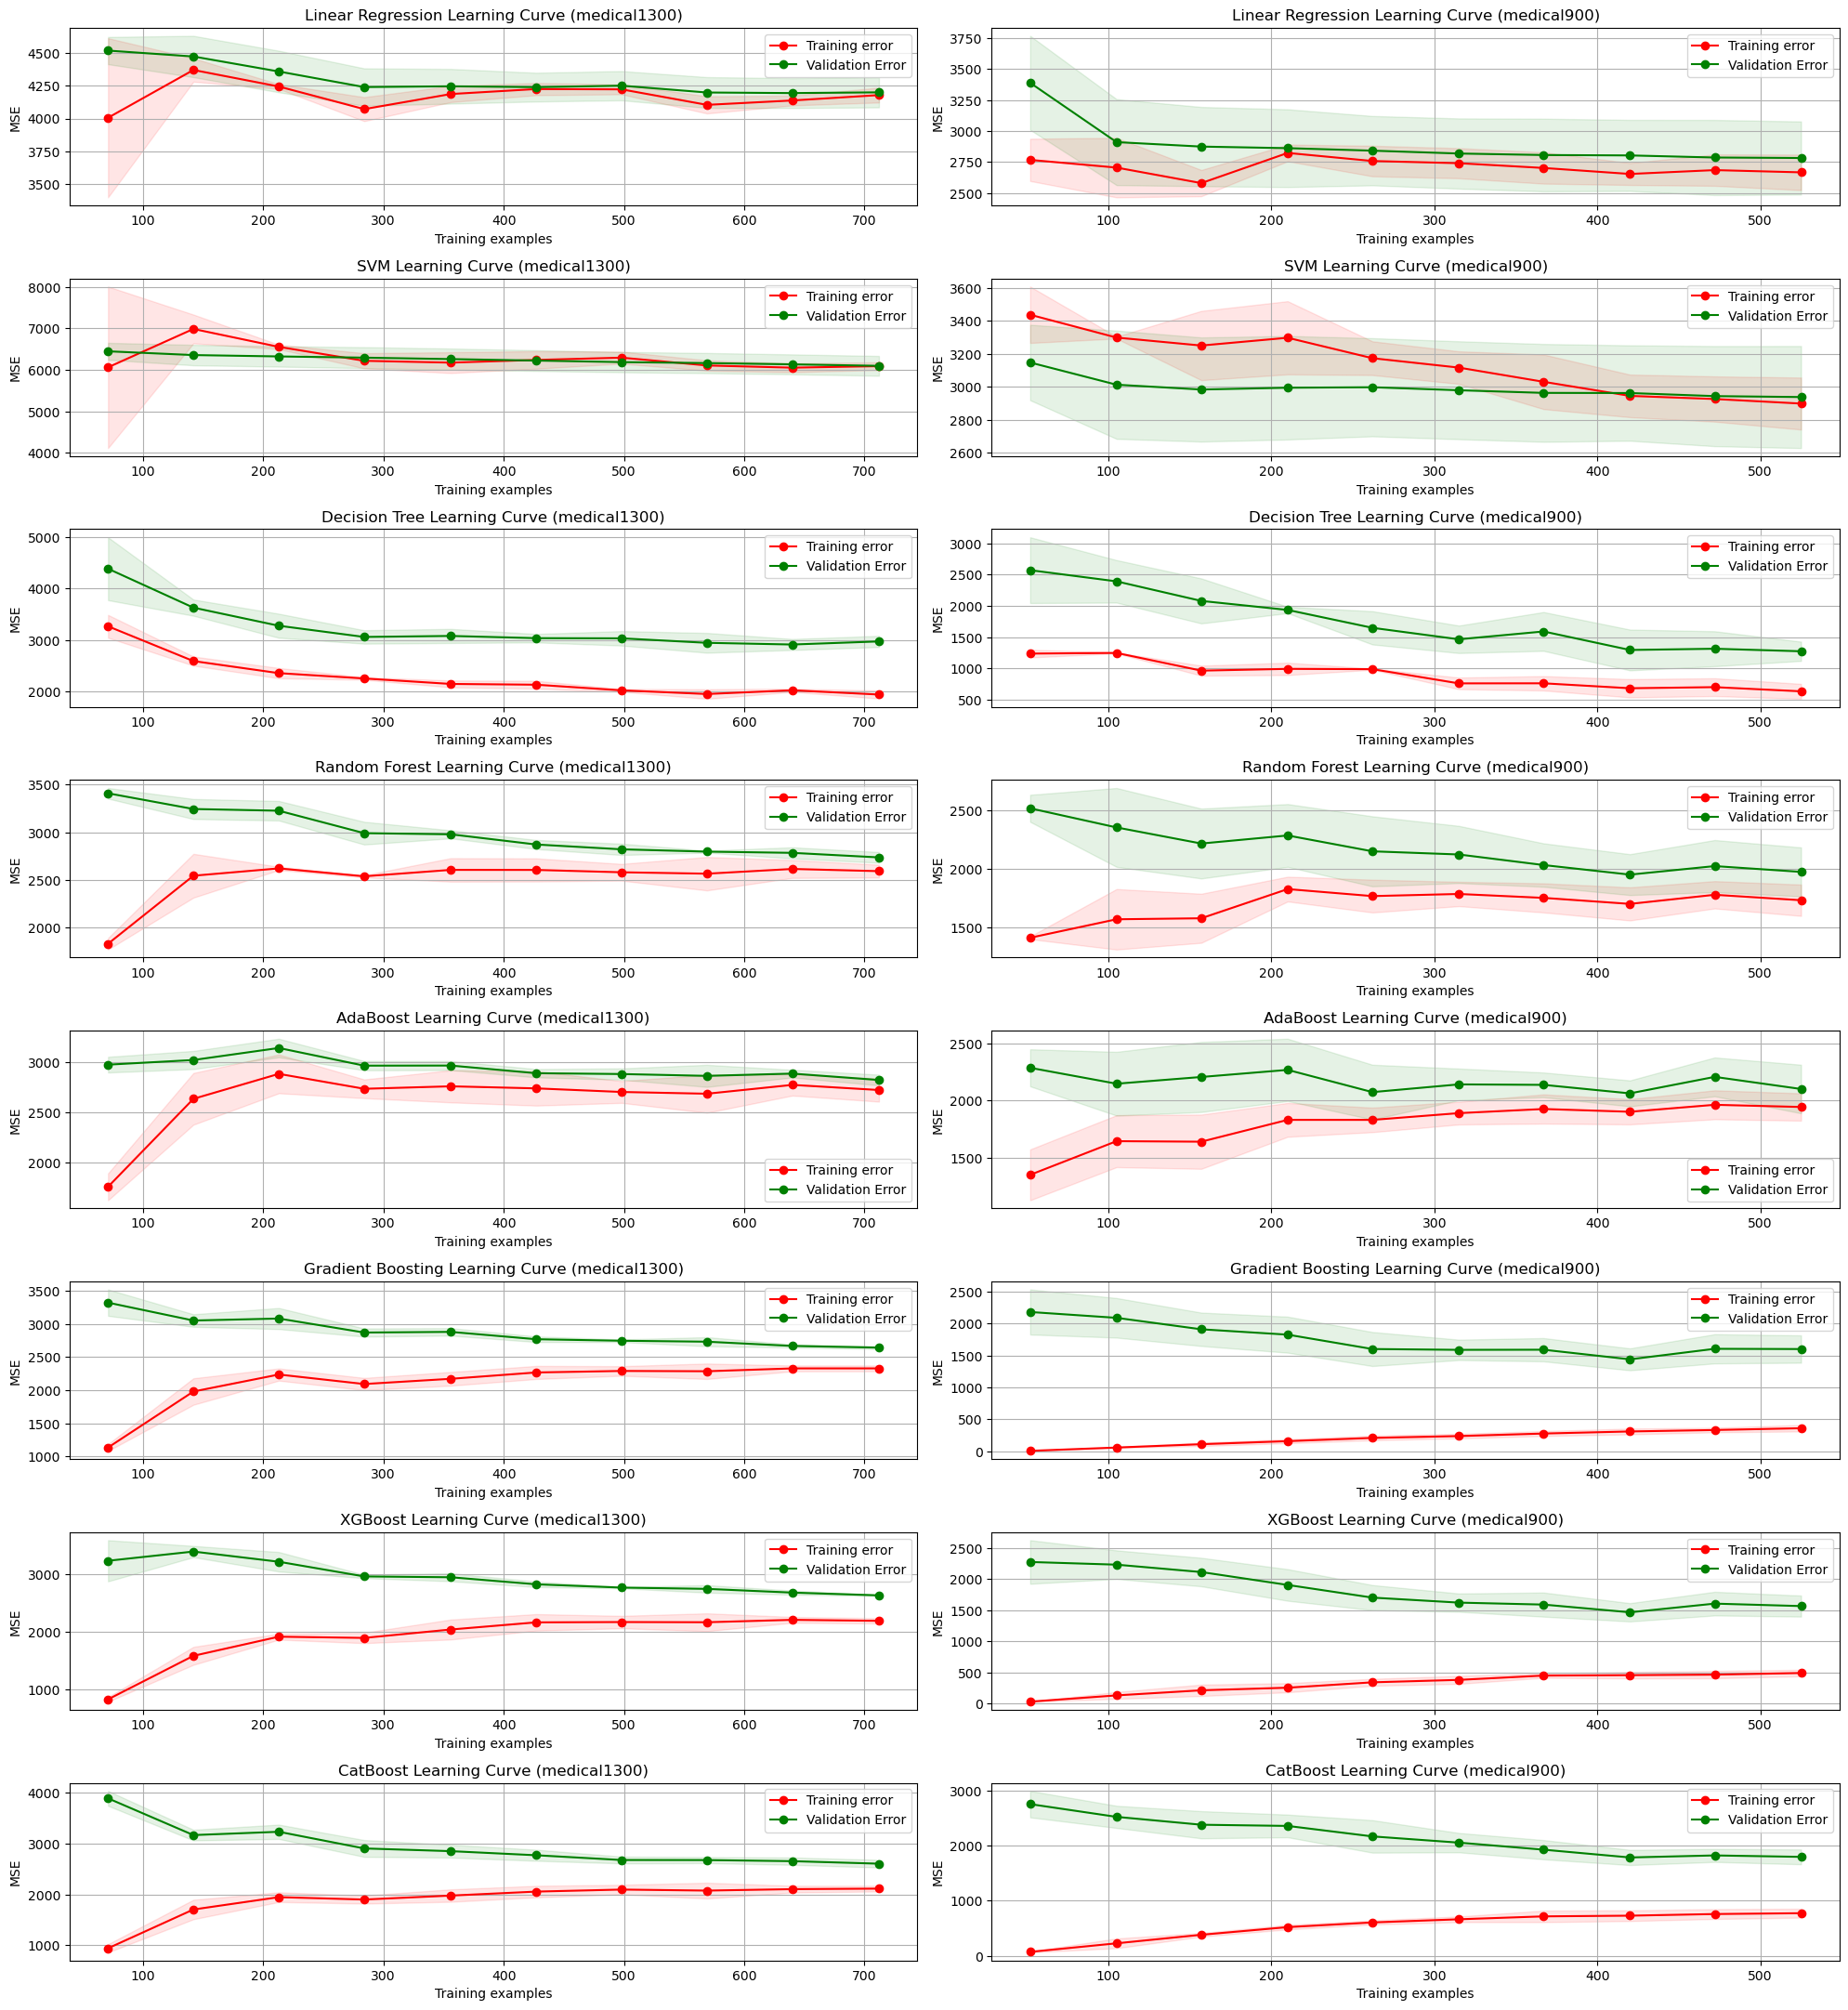

In [131]:
# Function to plot learning curves
def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=42)

    train_scores_mean = -train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)
    test_scores_std = test_scores.std(axis=1)

    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("MSE")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training error")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Validation Error")

    plt.legend(loc="best")
    return plt

plt.figure(figsize=(20, 24))

model_names_1300 = [
    'Linear Regression', 'SVM', 'Decision Tree', 'Random Forest',
    'AdaBoost', 'Gradient Boosting', 'XGBoost', 'CatBoost'
]
for i, name in enumerate(model_names_1300, start=1):
    plt.subplot(9, 2, i * 2 - 1)
    plot_learning_curve(models_1300[name], X_train_1300, y_train_1300, f"{name} Learning Curve (medical1300)")

model_names_900 = [
    'Linear Regression', 'SVM', 'Decision Tree', 'Random Forest',
    'AdaBoost', 'Gradient Boosting', 'XGBoost', 'CatBoost'
]
for i, name in enumerate(model_names_900, start=1):
    plt.subplot(9, 2, i * 2)
    plot_learning_curve(models_900[name], X_train_900, y_train_900, f"{name} Learning Curve (medical900)")

plt.tight_layout()
plt.show()

## MODEL EVALUATION METRICS COMPARISON

In [146]:
# Function to plot and compare metrics
def plot_metrics(results, dataset_name):
    metrics = ['MAE', 'MSE', 'RMSE', 'R2']
    models = list(results.keys())

    fig, axes = plt.subplots(4, 1, figsize=(12, 20))
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        values = [results[model][metric] for model in models]
        axes[i].bar(models, values, color=['skyblue', 'lightgreen', 'salmon', 'lightblue', 'lightcoral', 'lightpink', 'lightseagreen', 'lightgoldenrodyellow', 'lightsteelblue'])
        axes[i].set_title(f'{metric} Comparison for {dataset_name}')
        axes[i].set_ylabel(metric)
        axes[i].set_xlabel('Model')
        for j, v in enumerate(values):
            axes[i].text(j, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


Metrics Evaluation for medical1300.csv


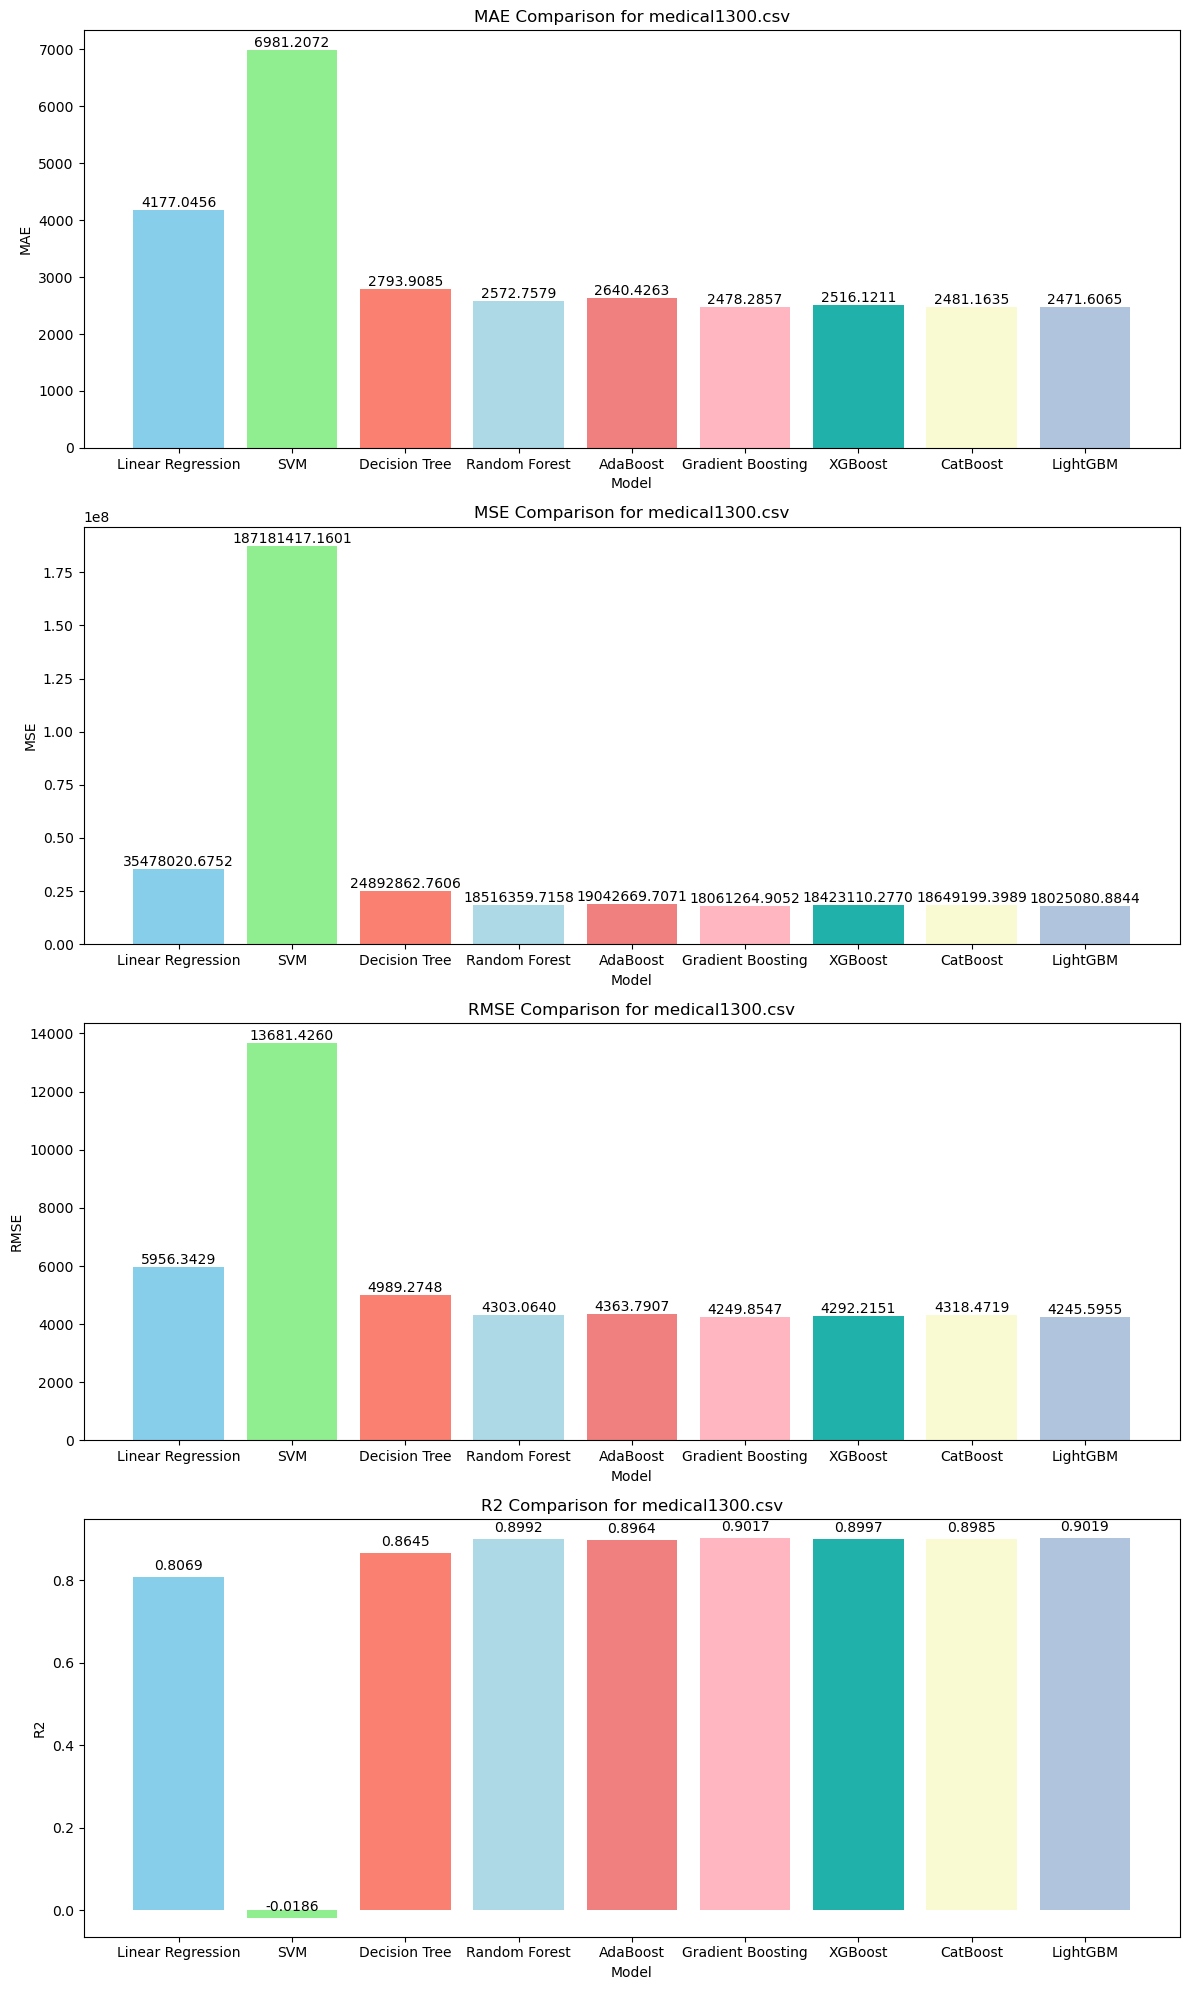

In [147]:
# Load all metrics
linreg_metrics = pickle.load(open('metrics/Linear Regression_1300.pkl', 'rb'))
svm_metrics = pickle.load(open('metrics/SVM_1300.pkl', 'rb'))
dt_metrics = pickle.load(open('metrics/Decision Tree_1300.pkl', 'rb'))
rf_metrics = pickle.load(open('metrics/Random Forest_1300.pkl', 'rb'))
ada_metrics = pickle.load(open('metrics/AdaBoost_1300.pkl', 'rb'))
gb_metrics = pickle.load(open('metrics/Gradient Boosting_1300.pkl', 'rb'))
xgb_metrics = pickle.load(open('metrics/XGBoost_1300.pkl', 'rb'))
catboost_metrics = pickle.load(open('metrics/CatBoost_1300.pkl', 'rb'))
lgbm_metrics = pickle.load(open('metrics/LightGBM_results_1300.pkl', 'rb'))

# Aggregate the loaded metrics
results_1300 = {
    'Linear Regression': linreg_metrics,
    'SVM': svm_metrics,
    'Decision Tree': dt_metrics,
    'Random Forest': rf_metrics,
    'AdaBoost': ada_metrics,
    'Gradient Boosting': gb_metrics,
    'XGBoost': xgb_metrics,
    'CatBoost': catboost_metrics,
    'LightGBM': lgbm_metrics
}

# Plot metrics for medical1300.csv
print("Metrics Evaluation for medical1300.csv")
plot_metrics(results_1300, 'medical1300.csv')


Metrics Evaluation for medical900.csv


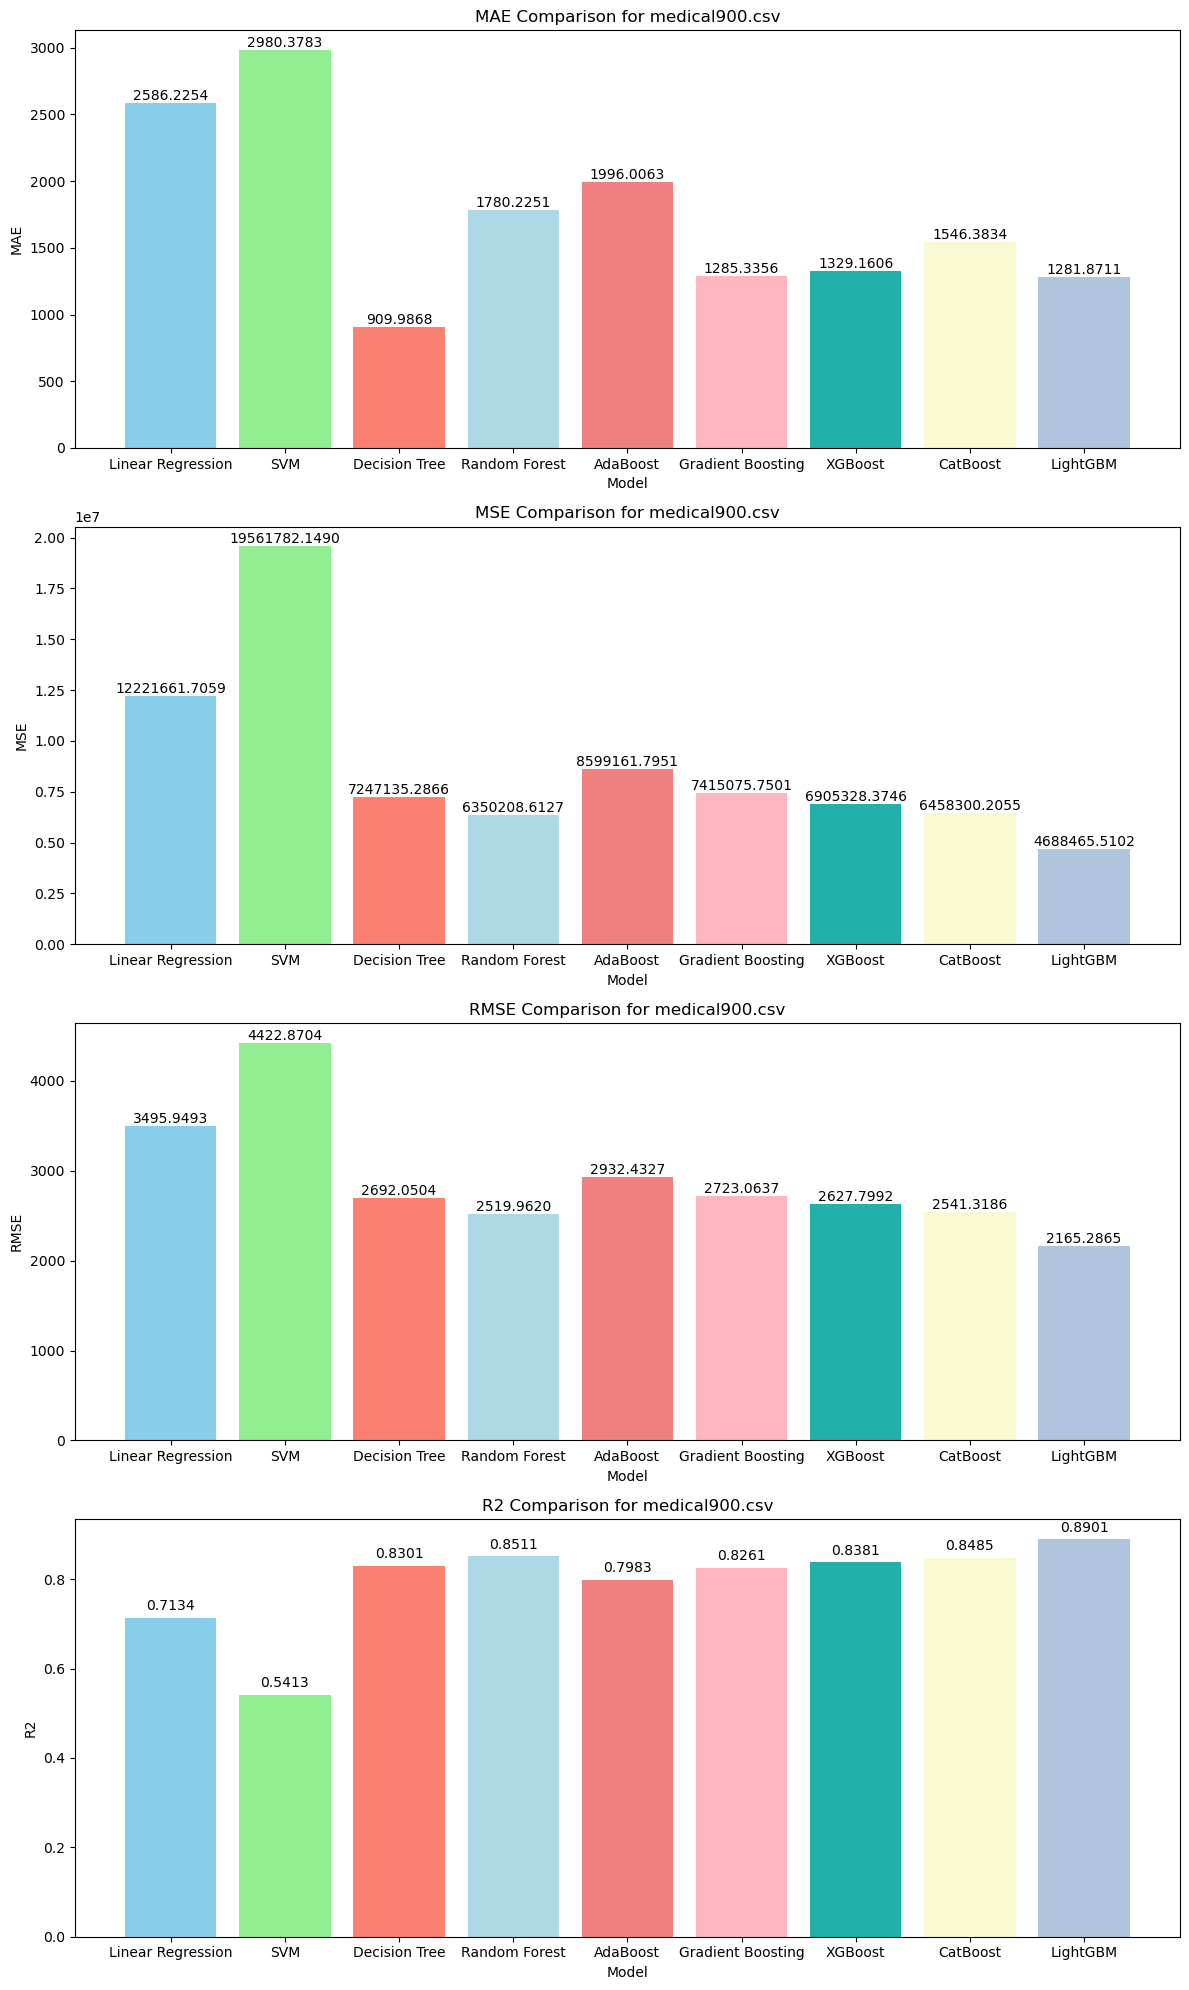

In [148]:
# Load all metrics
linreg_metrics = pickle.load(open('metrics/Linear Regression_900.pkl', 'rb'))
svm_metrics = pickle.load(open('metrics/SVM_900.pkl', 'rb'))
dt_metrics = pickle.load(open('metrics/Decision Tree_900.pkl', 'rb'))
rf_metrics = pickle.load(open('metrics/Random Forest_900.pkl', 'rb'))
ada_metrics = pickle.load(open('metrics/AdaBoost_900.pkl', 'rb'))
gb_metrics = pickle.load(open('metrics/Gradient Boosting_900.pkl', 'rb'))
xgb_metrics = pickle.load(open('metrics/XGBoost_900.pkl', 'rb'))
catboost_metrics = pickle.load(open('metrics/CatBoost_900.pkl', 'rb'))
lgbm_metrics = pickle.load(open('metrics/LightGBM_results_900.pkl', 'rb'))

# Aggregate the loaded metrics
results_900 = {
    'Linear Regression': linreg_metrics,
    'SVM': svm_metrics,
    'Decision Tree': dt_metrics,
    'Random Forest': rf_metrics,
    'AdaBoost': ada_metrics,
    'Gradient Boosting': gb_metrics,
    'XGBoost': xgb_metrics,
    'CatBoost': catboost_metrics,
    'LightGBM': lgbm_metrics
}

# Plot metrics for medical1300.csv
print("Metrics Evaluation for medical900.csv")
plot_metrics(results_900, 'medical900.csv')